In [168]:
from utils import load_data, check_gpu, check_dir
from clean_session import preprocess_sessions
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import catboost as cat
import matplotlib.pyplot as plt
from clean_session import preprocess_sessions
from manual_encoding import action_encoding, click_view_encoding, meta_encoding
from hotel2vec import hotel2vec
import datetime
%matplotlib inline
%load_ext autoreload
%autoreload 2
def fprint(df, name):
    print(f'{name} shape: ({df.shape[0]:,}, {df.shape[1]})')
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
%%time
train_raw = load_data('train')
train_raw['timestamp'] = train_raw['timestamp'].apply(lambda t: datetime.datetime.utcfromtimestamp(t))
train_raw['nfilters'] = train_raw['current_filters'].str.split('|').str.len()
train = train_raw[(train_raw.action_type == 'clickout item') & (train_raw.impressions.notna())].copy()

CPU times: user 28 s, sys: 1.9 s, total: 29.9 s
Wall time: 29.9 s


In [171]:
fprint(train, 'train')

train shape: (1,586,586, 13)


In [137]:
# %%time
# # also get test
# test = load_data('test')#, nrows=1000000)
# fprint(test, 'raw test')
# test = test[(test.action_type == 'clickout item') & (test.impressions.notna()) & (test.reference.notna())].reset_index(drop=True)
# fprint(test, 'test after')

In [138]:
# test_sub = load_data('submission_popular')

In [4]:
%%time
def session_duration(x):
    return x.max() - x.min()
# session_fts = train.groupby('session_id').agg({'session_id': 'size', 'timestamp': session_duration})
session_fts = train.groupby('session_id').size().reset_index(name='session_size')

CPU times: user 1.2 s, sys: 0 ns, total: 1.2 s
Wall time: 1.2 s


In [5]:
%%time
train_last = train.groupby('session_id').last().reset_index()

CPU times: user 2.99 s, sys: 0 ns, total: 2.99 s
Wall time: 2.98 s


In [ ]:
fprint(train_last, 'trian_last')

In [6]:
train_last = pd.merge(train_last, session_fts, on='session_id')

### user_id

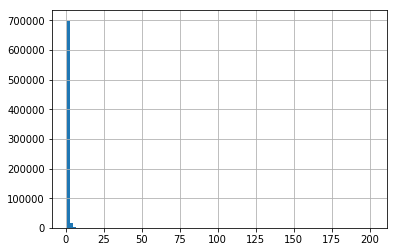

In [53]:
# train_last.groupby('user_id').size()
train_last.user_id.value_counts().hist(bins=100)

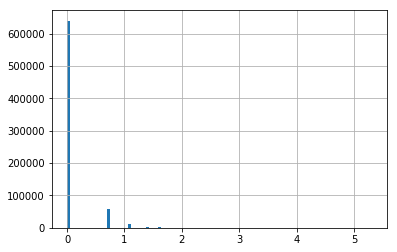

In [54]:
# train_last.groupby('user_id').size()
np.log(train_last.user_id.value_counts()).hist(bins=100)

In [55]:
train_last.user_id.nunique()

717774

In [56]:
train_user_ids = train_last.user_id.unique()

In [57]:
test_user_ids = test.user_id.unique()

In [58]:
sub_ids = test_sub.user_id.unique()

In [59]:
len(set(train_user_ids).intersection(sub_ids))

26913

In [60]:
sub_ids.shape

(250852,)

In [61]:
26913/sub_ids.shape[0]

0.1072863680576595

### what are the ones click on index 0 look like and the ones with rest index

In [64]:
one_sids = train_last[train_last.target==0].session_id
rest_sids = train_last[train_last.target!=0].session_id

In [204]:
oid = np.random.choice(one_sids, 1)[0]
rid = np.random.choice(rest_sids, 1)[0]
oid, rid

('fe9b9d3a905bb', '1258fb24f726f')

In [205]:
print('target:', train_last[train_last.session_id==oid].target.values[0], '| session_size:',
     train_last[train_last.session_id==oid].session_size.values[0], '| user freq:',
     train_last[train_last.session_id==oid].user_id.size, '\n')
for i in train[train.session_id==oid].reset_index(drop=True).values:
    print(i)

target: 0 | session_size: 1 | user freq: 1 

['YOQC4S5JQE3C' 'fe9b9d3a905bb' Timestamp('2018-11-01 14:56:37') 2
 'clickout item' '5659482' 'NL' 'Essen, Germany' 'desktop' nan
 '5659482|6411|5213472|1942169|1909221|6421|6416|433571|6409|4645172|7771100|8004290|8209168|2548188|1288612|2300514|6413|465701|14797|86566|6426|6410|920187|6420|109482'
 '91|125|121|118|83|145|138|119|105|81|76|98|149|91|134|121|107|108|107|105|148|109|125|80|135'
 nan]


In [206]:
ps = np.concatenate(train[train.session_id==oid].prices.drop_duplicates().str.split('|').values)
ps = [int(i) for i in ps]
ps = np.sort(ps)
ps

array([ 76,  80,  81,  83,  91,  91,  98, 105, 105, 107, 107, 108, 109,
       118, 119, 121, 121, 125, 125, 134, 135, 138, 145, 148, 149])

---

In [207]:
print('target:', train_last[train_last.session_id==rid].target.values[0], '| session_size:',
     train_last[train_last.session_id==rid].session_size.values[0], '| user freq:',
     train_last[train_last.session_id==rid].user_id.size, '\n')
for i in train[train.session_id==rid].reset_index(drop=True).values:
    print(i)

target: 1 | session_size: 3 | user freq: 1 

['7CUYQ7J24DQ7' '1258fb24f726f' Timestamp('2018-11-05 20:09:38') 1
 'clickout item' '1312459' 'GR' 'Neochori, Greece' 'mobile' nan
 '1037404|1312459|3205422|1740819|2565490|8107466|435461|1289612|3076386|1479113|7245992|2349758|2678238|6009484|1200802|2654896|2467574'
 '65|50|50|100|70|70|72|52|35|85|80|65|65|125|45|50|45' nan]
['7CUYQ7J24DQ7' '1258fb24f726f' Timestamp('2018-11-05 20:10:38') 2
 'clickout item' '3205422' 'GR' 'Neochori, Greece' 'mobile' nan
 '1037404|1312459|3205422|1740819|2565490|8107466|435461|1289612|3076386|1479113|7245992|2349758|2678238|6009484|1200802|2654896|2467574'
 '65|50|50|100|70|70|72|52|35|85|80|65|65|125|45|50|45' nan]
['7CUYQ7J24DQ7' '1258fb24f726f' Timestamp('2018-11-05 20:28:03') 8
 'clickout item' '3205422' 'GR' 'Neochori, Greece' 'mobile' nan
 '1312459|3205422|1740819|2565490|8107466|435461|1289612|2349758|1479113|1037404|6009484|7245992|2678238|1200802|2654896'
 '50|50|100|70|70|72|52|65|85|65|125|80|65

In [208]:
ps = train[train.session_id==rid].prices.drop_duplicates().str.split('|').iloc[-1]
ps = np.sort([int(i) for i in ps])
ps

array([ 45,  50,  50,  50,  52,  65,  65,  65,  70,  70,  72,  80,  85,
       100, 125])

### check raw

In [209]:
train_raw[train_raw.session_id==oid].reset_index(drop=True)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,nfilters
0,YOQC4S5JQE3C,fe9b9d3a905bb,2018-11-01 14:54:58,1,search for destination,"Essen, Germany",NL,"Essen, Germany",desktop,NaN,NaN,NaN,NaN
1,YOQC4S5JQE3C,fe9b9d3a905bb,2018-11-01 14:56:37,2,clickout item,5659482,NL,"Essen, Germany",desktop,NaN,5659482|6411|5213472|1942169|1909221|6421|6416...,91|125|121|118|83|145|138|119|105|81|76|98|149...,NaN


In [211]:
train_raw[train_raw.session_id==rid].reset_index(drop=True)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,nfilters
0,7CUYQ7J24DQ7,1258fb24f726f,2018-11-05 20:09:38,1,clickout item,1312459,GR,"Neochori, Greece",mobile,NaN,1037404|1312459|3205422|1740819|2565490|810746...,65|50|50|100|70|70|72|52|35|85|80|65|65|125|45...,NaN
1,7CUYQ7J24DQ7,1258fb24f726f,2018-11-05 20:10:38,2,clickout item,3205422,GR,"Neochori, Greece",mobile,NaN,1037404|1312459|3205422|1740819|2565490|810746...,65|50|50|100|70|70|72|52|35|85|80|65|65|125|45...,NaN
2,7CUYQ7J24DQ7,1258fb24f726f,2018-11-05 20:15:29,3,interaction item info,1037404,GR,"Neochori, Greece",mobile,NaN,NaN,NaN,NaN
3,7CUYQ7J24DQ7,1258fb24f726f,2018-11-05 20:15:39,4,interaction item deals,1037404,GR,"Neochori, Greece",mobile,NaN,NaN,NaN,NaN
4,7CUYQ7J24DQ7,1258fb24f726f,2018-11-05 20:15:49,5,change of sort order,interaction sort button,GR,"Neochori, Greece",mobile,NaN,NaN,NaN,NaN
5,7CUYQ7J24DQ7,1258fb24f726f,2018-11-05 20:15:59,6,change of sort order,interaction sort button,GR,"Neochori, Greece",mobile,NaN,NaN,NaN,NaN
6,7CUYQ7J24DQ7,1258fb24f726f,2018-11-05 20:16:14,7,interaction item info,1037404,GR,"Neochori, Greece",mobile,NaN,NaN,NaN,NaN
7,7CUYQ7J24DQ7,1258fb24f726f,2018-11-05 20:28:03,8,clickout item,3205422,GR,"Neochori, Greece",mobile,NaN,1312459|3205422|1740819|2565490|8107466|435461...,50|50|100|70|70|72|52|65|85|65|125|80|65|45|50,NaN


In [167]:
1541231265 - 1541231272

-7

In [141]:
len(set(train_raw.session_id.unique()).intersection(test.session_id.unique()))

10

### current_filters

In [ ]:
train_last.shape

In [ ]:
filters_counts = train_last.current_filters.value_counts()

In [ ]:
filters_counts.head()

In [ ]:
train_last.current_filters.nunique()

In [ ]:
train_last['cfs'] = train_last.current_filters.str.split('|')

In [ ]:
all_cfs = train_last[train_last.cfs.notna()].cfs.values
all_cfs = [j for i in all_cfs for j in i]

In [ ]:
all_cfs_counts = pd.value_counts(all_cfs)
all_cfs_counts.head()

In [ ]:
pd.value_counts(all_cfs, normalize=True).cumsum().head(20)

In [ ]:
all_cfs_counts.index[pd.DataFrame({'cfs': all_cfs_counts.index}).cfs.str.contains(r'[^(e)]sort', case=False)]

In [ ]:
all_cfs_counts.hist(bins=20)

In [ ]:
all_cfs_counts.shape

In [ ]:
# all_cfs_counts.index.values

In [ ]:
train_last.current_filters.isna().sum()

In [ ]:
train_last.shape

In [ ]:
655653/train_last.shape[0]

In [ ]:
train_last['nimps'] = train_last.impressions.str.split('|').str.len()

What is the length of the impressions for these with nan current_filters?

In [ ]:
train_last.loc[train_last.current_filters.isna(), 'nimps'].value_counts(normalize=True).head()

In [ ]:
train_last.nimps.value_counts(normalize=True).head()

In [ ]:
train_last.loc[train_last.current_filters.notna(), 'nimps'].value_counts(normalize=True).head()

What is the size of the session for these with nan current_filters?

In [ ]:
train_last.loc[train_last.current_filters.isna(), 'session_size'].value_counts(normalize=True).head()

In [ ]:
train_last.loc[train_last.current_filters.notna(), 'session_size'].value_counts(normalize=True).head()

In [ ]:
train_last.session_size.value_counts(normalize=True).head()

### Suppose we build extremly simple baseline

In [ ]:
train_last['ncfs'] = train_last.cfs.str.len()

In [ ]:
train_last['prices'] = train_last.prices.str.split('|')

In [ ]:
%%time
train_last['prices'] = train_last.prices.apply(lambda x: np.pad(x, (0, 25-len(x)), mode='constant'))

In [ ]:
%%time
train_last['prices'] = train_last.prices.apply(lambda x: [int(p) for p in x])

In [8]:
train_last['impressions'] = train_last['impressions'].str.split('|')
train_last['impressions'] = train_last['impressions'].apply(lambda x: [int(i) for i in x])

### shuffle the impressions (together with the prices)

In [ ]:
# %%time
# # add some shuffling
# train_last['data'] = 'original'
# train_last_shuffle = train_last[train_last.current_filters.isna()].reset_index(drop=True)
# train_last_shuffle['data'] = 'shuffled'

In [ ]:
# imps = train_last_shuffle['impressions'].values
# prices = train_last_shuffle['prices'].values

In [ ]:
# ind_shuffle = [np.arange(len(i), dtype=int) for i in imps]

In [ ]:
# %%time
# _ = [np.random.shuffle(i) for i in ind_shuffle]

In [ ]:
# %%time
# train_last_shuffle['impressions'] = [list(np.array(imps[i])[ind_shuffle[i]]) for i in range(len(train_last_shuffle))]

In [ ]:
# %%time
# train_last_shuffle['prices'] = [list(np.array(prices[i])[ind_shuffle[i]]) for i in range(len(train_last_shuffle))]

In [ ]:
# # def shuffle_impressions(x):
# #     x_cp = np.array(x)
# #     np.random.shuffle(x_cp)
# #     return list(x_cp)
# # train_last_shuffle['impressions'] = train_last_shuffle['impressions'].apply(shuffle_impressions)
# train_last = pd.concat([train_last, train_last_shuffle], axis=0, ignore_index=True)

In [ ]:
# add country infomation
train_last['country'] = train_last.city.str.split(',').str[1]

In [9]:
%%time
# make target
def make_target(x):
    try:
        return x.impressions.index(int(x.reference))
    except Exception as e:
        return 25
train_last['target'] = train_last.apply(make_target, axis=1)

CPU times: user 22.1 s, sys: 10.7 ms, total: 22.1 s
Wall time: 22.1 s


In [11]:
# train_last.head()

In [29]:
# target distribution for different session size
size_target = train_last.groupby('session_size')['target'].value_counts()
# size_target.unstack(level=-1)

In [30]:
def confusion_matrix(size_target, normalize='row', level=0, log_scale=False):
    mat = size_target.unstack(level=level).fillna(0)    
    if normalize == 'row':
        row_sum = mat.sum(axis=1)
        mat = mat.div(row_sum, axis=0)
        log_scale = False
    elif normalize == 'column':
        col_sum = mat.sum(axis=0)
        mat = mat.div(col_sum, axis=1)
        log_scale = False
    # plot
    fig = plt.figure(figsize=(35,10))
    ax = fig.add_subplot(111)
    if log_scale:
        cax = ax.matshow(np.log1p(mat), interpolation='nearest')#, cmap='coolwarm')#, aspect='auto')
    else:
        cax = ax.matshow(mat, interpolation='nearest')#, cmap='coolwarm')#, aspect='auto')
    fig.colorbar(cax)
    ax.set_xlabel(f'{mat.columns.name}')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel(f'{mat.index.name}')
    
    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_xticklabels(list(mat.columns.astype(str)), rotation=90)
    ax.set_yticks(np.arange(mat.shape[0]))
    _ = ax.set_yticklabels(list(mat.index.astype(str)))
    return mat

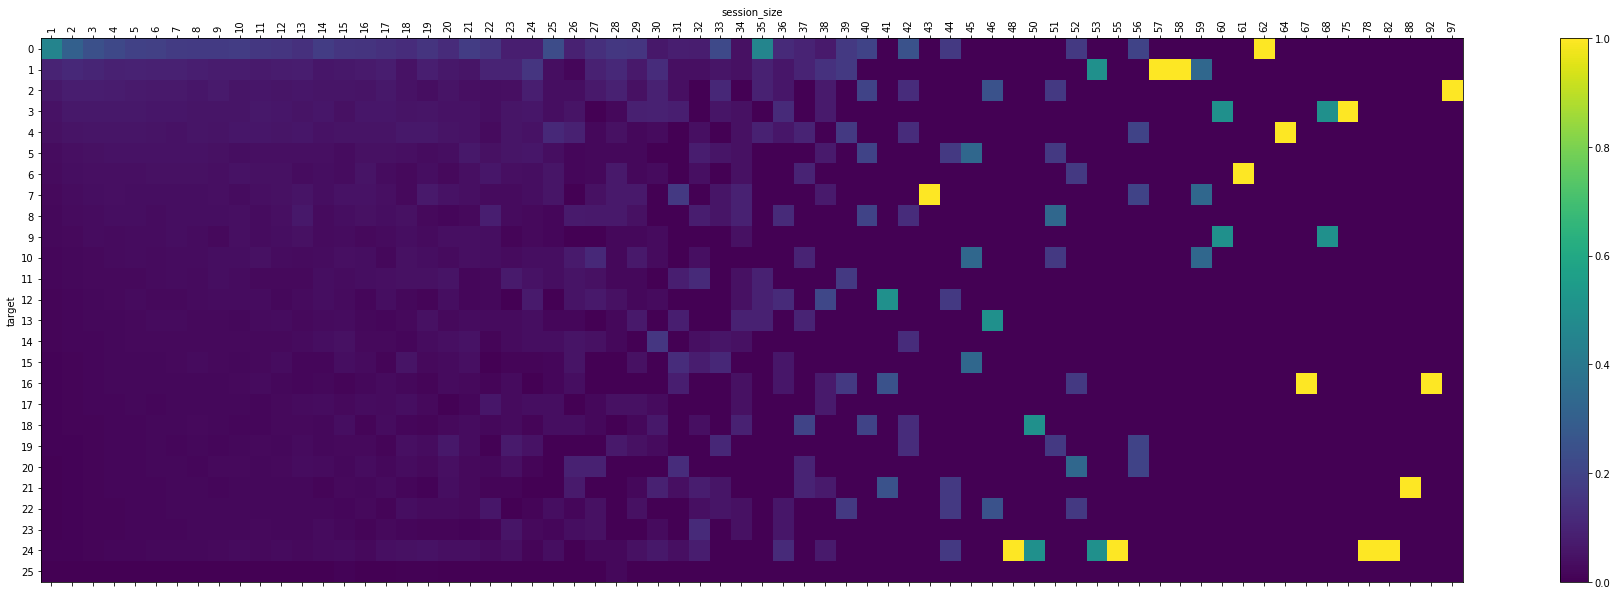

In [31]:
_ = confusion_matrix(size_target, normalize='column', level=0)

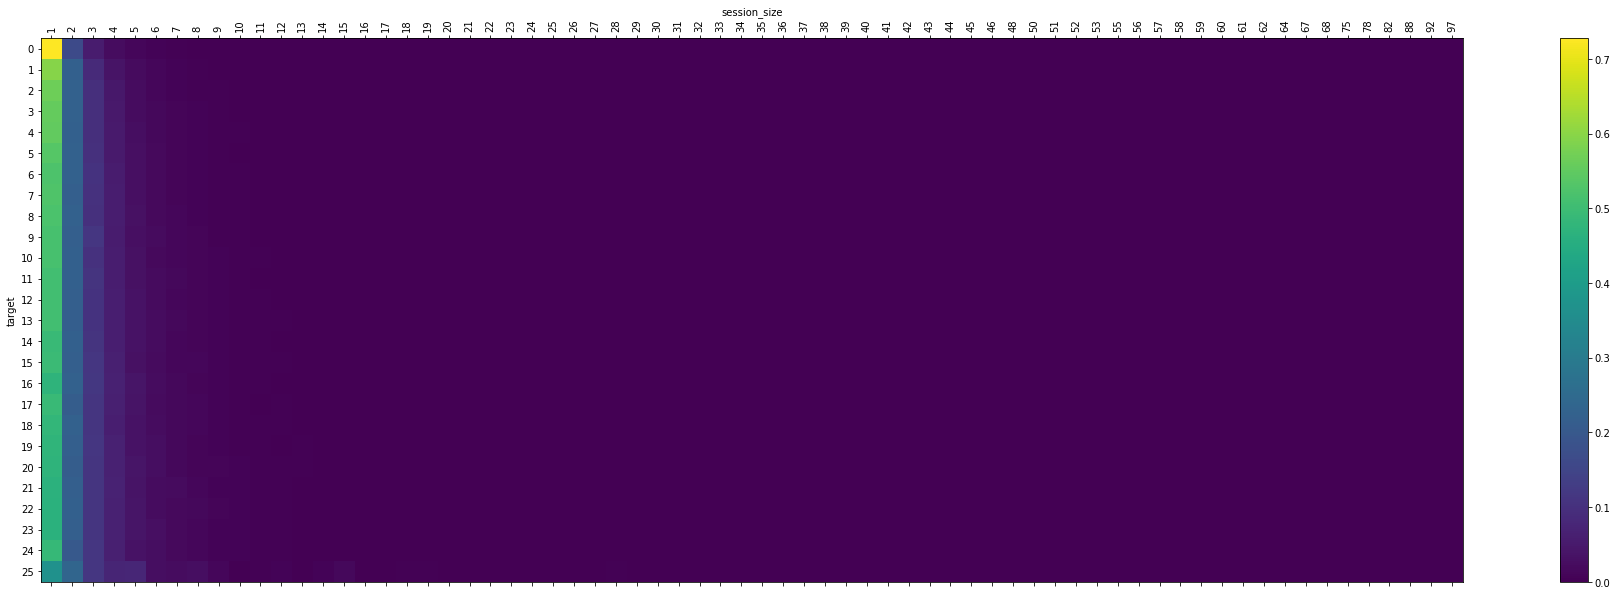

In [33]:
_ = confusion_matrix(size_target, normalize='row', level=0)

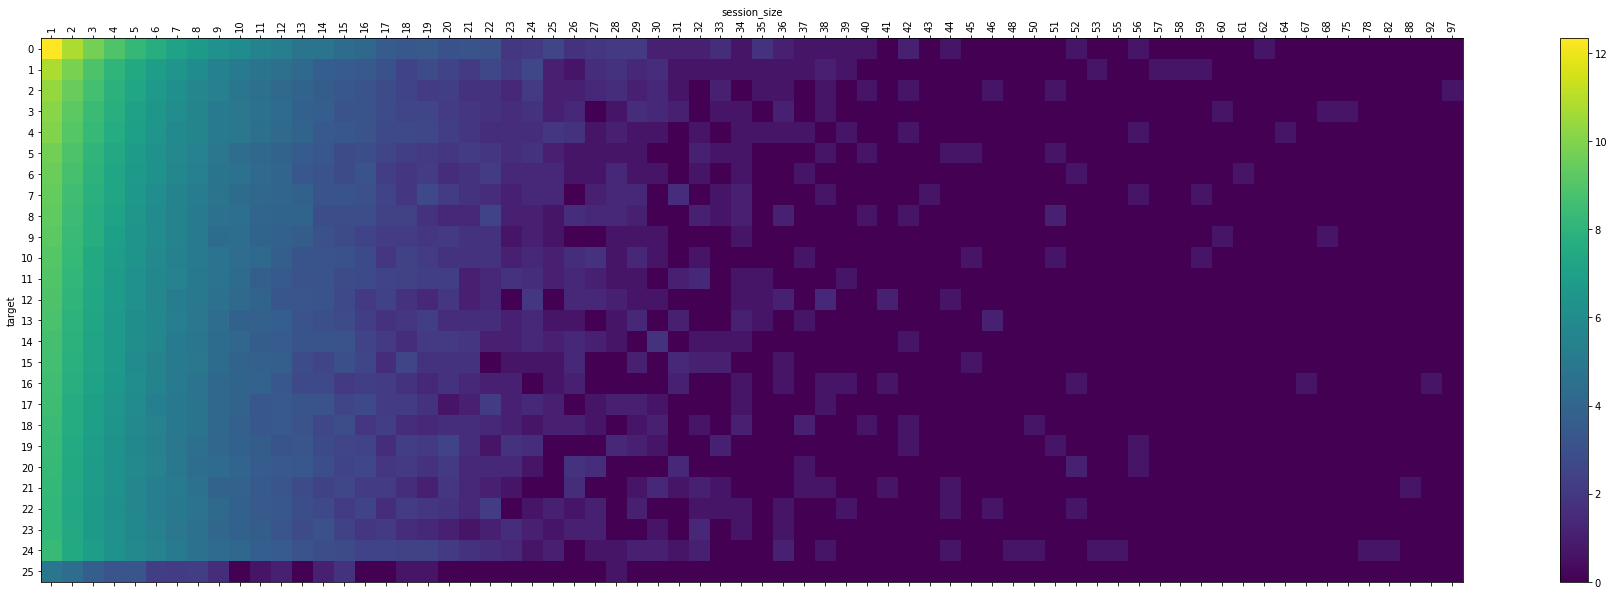

In [40]:
_ = confusion_matrix(size_target, normalize=None, log_scale=True)

---

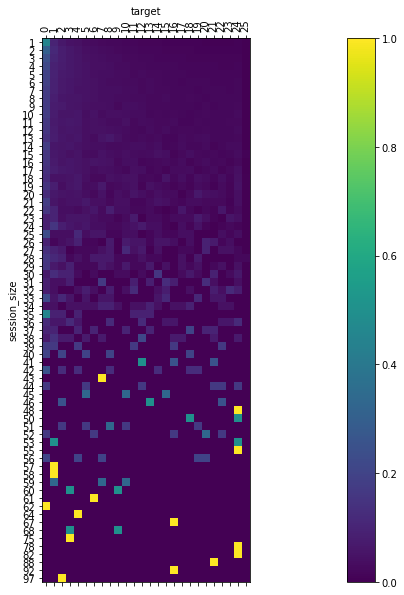

In [32]:
_ = confusion_matrix(size_target, normalize='row', level=-1)

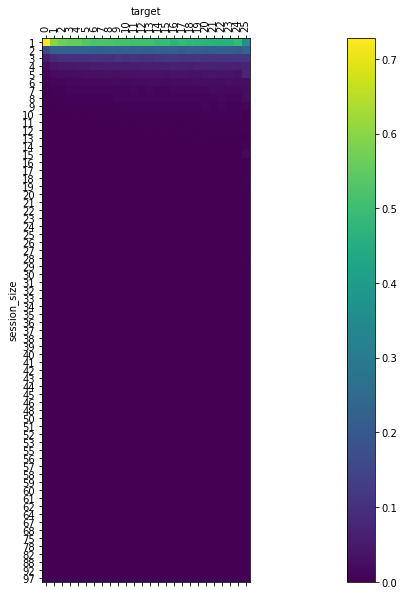

In [35]:
_ = confusion_matrix(size_target, normalize='column', level=-1)

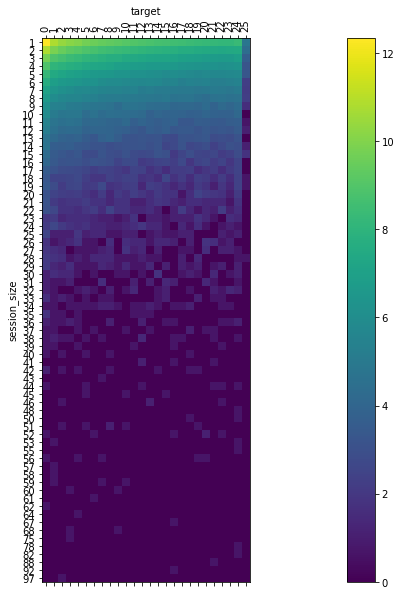

In [41]:
_ = confusion_matrix(size_target, normalize=None, log_scale=True, level=-1)

In [38]:
non_zero_target = train_last[train_last['target']!=0

(1586586, 12)

### Compare with popularity based

In [ ]:
%%time
# compute the popularity counts
pop = train_last.groupby('reference').size().reset_index(name='ctn')
pop.sort_values(by='ctn', ascending=True)
pop['reference'] = pop.reference.astype(int)
pop_map = dict(pop[['reference', 'ctn']].values)
train_last['popularity'] = train_last.impressions.apply(lambda x: [pop_map[i] if i in pop_map.keys() else -1 for i in x ])
del pop, pop_map
train_last['ptarget'] = train_last.popularity.apply(lambda x: np.argmax(x))

In [ ]:
%%time
def assign_pop_target(x):
    if x.target == 25:
        return np.nan
    else:
        return 1/(np.argsort(x.popularity)[::-1][x.target]+1)
train_last['popularity_rr'] = train_last.apply(assign_pop_target, axis=1) 

In [ ]:
train_last.popularity_rr.dropna().mean()

In [ ]:
prr = train_last['popularity_rr']
ptarget = train_last['ptarget']
train_last = train_last.drop(['ptarget', 'popularity', 'popularity_rr'], axis=1)

In [ ]:
train_last = train_last.drop(['user_id', 'action_type', 'current_filters', 'impressions', 'cfs'], axis=1)

In [ ]:
train_last.head()

In [ ]:
price_df = pd.DataFrame(train_last.prices.to_list(), columns=[f'price_{i}' for i in range(25)])

In [ ]:
del train_last['prices']
train_last = pd.concat([train_last, price_df], axis=1)

In [ ]:
train_last.head()

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
folds = StratifiedKFold(n_splits=5)

In [ ]:
targets = train_last.target.values
sids = train_last.session_id.values
train_last = train_last.drop(['session_id', 'reference', 'target'], axis=1)

In [ ]:
from utils import check_gpu
device = 'GPU' if check_gpu() else 'CPU'
params = {'iterations': 300,
          'learning_rate': 0.03,
          'depth': 10,
          'task_type': device,
          'loss_function': 'MultiClass',
          'custom_metric': ['MultiClass', 'Accuracy'],
          'eval_metric': 'MultiClass'}

In [ ]:
train_last.head()

In [ ]:
categorical_cols = ['platform', 'city', 'country', 'device']
# del train_last['data']
# # categorical_cols = ['platform', 'city', 'country','device', 'data']
# categorical_ind = [k for k, v in enumerate(train_last.columns) if v in categorical_cols]

In [ ]:
def post_processing(x, pred):
    pp = np.zeros(26)
    pp[0] = 1
    pp_mask = x.nimps == 1
    if sum(pp_mask) == 0:
        print('no length 1s to post-process')
    else:
        print(f'{sum(pp_mask)} length 1s post-processed')
        pred[pp_mask] = np.tile(pp, (sum(pp_mask), 1))
    return pred

def cal_mrr(pred, ytrue, raw=False):
    rr = 1/(np.where(np.argsort(pred)[:, ::-1] == ytrue.reshape(-1, 1))[1] + 1)
    if raw:
        return rr
    else:
        return np.mean(rr)

In [ ]:
train_last.head()

In [ ]:
for fold, (trn_ind, val_ind) in enumerate(folds.split(targets, targets)):
    print(f'train len: {len(trn_ind):,} val len: {len(val_ind):,}')
    x_trn, y_trn = train_last.iloc[trn_ind], targets[trn_ind]
#     x_trn_shuffle, y_trn_shuffle = 
    x_val, y_val = train_last.iloc[val_ind], targets[val_ind]
#     x_val = x_val[x_val.data=='original']
#     y_val = y_val[x_val.data=='original']
#     del train_last['data'], x_trn['data'], x_val['data']
    
    # categorical_cols = ['platform', 'city', 'country','device', 'data']
    categorical_ind = [k for k, v in enumerate(train_last.columns) if v in categorical_cols]

    # train model
    clf = cat.CatBoostClassifier(**params)
    clf.fit(x_trn.values, y_trn,
            cat_features=categorical_ind,
            eval_set=(x_val.values, y_val),
            early_stopping_rounds=100,
            verbose=10,
            plot=True)
    
    trn_pred = clf.predict_proba(x_trn.values)
    val_pred = clf.predict_proba(x_val.values)
    
    trn_mrr = cal_mrr(trn_pred, y_trn)
    val_mrr = cal_mrr(val_pred, y_val)
    print(f'train: {trn_mrr:.5f}, val: {val_mrr:.5f}')
    
    ptrn_mrr = cal_mrr(post_processing(x_trn, trn_pred), y_trn)
    pval_mrr = cal_mrr(post_processing(x_val, val_pred), y_val)
    print(f'train: {ptrn_mrr:.5f}, val: {pval_mrr:.5f}')
    
    break

NOTE: 
1) with shuffling impressions for all records, the performance goes down a lot mrr ~0.31
2) if only shuffle the ones where current filters are nan, we got the slightly better result ~0.38

In [ ]:
from utils import plot_imp_cat
# get feature importance
trn_imp = clf.get_feature_importance(data=cat.Pool(data=x_trn, cat_features=categorical_ind),
                                     prettified=True)
plot_imp_cat(trn_imp, fold, mrr={'train': trn_mrr, 'val': val_mrr})

### look at the distribution of prediction

In [ ]:
# plt.subplot(212)
# equivalent but more general
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Predictions') 
_ = ax[0].hist(np.argmax(trn_pred, axis=1), bins=10)
_ = ax[1].hist(np.argmax(trn_pred, axis=1), bins=10, density=True)
_ = ax[0].set_xlim(-0.1, 24)
_ = ax[1].set_xlim(-0.1, 24)

In [ ]:
# _ = plt.hist(np.argmax(trn_pred, axis=0), bins=100)

In [ ]:
# y_trn
# _ = plt.hist(y_trn, bins=100)
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle('True label') 
_ = ax[0].hist(y_trn, bins=50)
_ = ax[1].hist(y_trn, bins=50, density=True)
_ = ax[0].set_xlim(-0.1, 24)
_ =ax[1].set_xlim(-0.1, 24)

In [ ]:
# # y_trn
# # _ = plt.hist(y_trn, bins=100)
# fig, ax = plt.subplots(nrows=1, ncols=2)
# fig.suptitle('True label') 
# _ = ax[0].hist(y_val, bins=50)
# _ = ax[1].hist(y_val, bins=50, density=True)
# _ = ax[0].set_xlim(-0.1, 24)
# _ =ax[1].set_xlim(-0.1, 24)

also look at the predictions if we use popularity rank

In [ ]:
# plt.subplot(212)
# equivalent but more general
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle('popurlarity based') 
_ = ax[0].hist(ptarget, bins=20)
_ = ax[1].hist(ptarget, bins=20, density=True)
_ = ax[0].set_xlim(-0.1, 24)
_ = ax[1].set_xlim(-0.1, 24)

In [ ]:
# validation prediction
# _ = plt.hist(np.argmax(val_pred, axis=0), bins=100)

In [ ]:
# # plt.subplot(212)
# # equivalent but more general
# fig, ax = plt.subplots(nrows=1, ncols=2)
# _ = ax[0].hist(np.argmax(val_pred, axis=1), bins=10)
# _ = ax[1].hist(np.argmax(val_pred, axis=1), bins=10, density=True)
# _ = ax[0].set_xlim(-0.1, 24)
# _ = ax[1].set_xlim(-0.1, 24)

### look at instances where the prediction was off

In [ ]:
trn_rr = cal_mrr(trn_pred, y_trn, raw=True)

In [ ]:
x_trn['rr'] = trn_rr

In [ ]:
x_trn['rr'].hist(bins=100)

In [ ]:
x_trn['rr'].value_counts(normalize=True).sort_index().cumsum()*100

In [ ]:
th = 0.25
demo_ids = sids[trn_ind][x_trn.rr<th]

In [ ]:
# randomly select an id
rid = np.random.choice(demo_ids, 1)[0]
rid

In [ ]:
rid = np.random.choice(demo_ids, 1)[0]
print(rid)
print(np.argmax(trn_pred[np.where(sids[trn_ind]==rid)]), y_trn[np.where(sids[trn_ind]==rid)])
train[train.session_id==rid].drop(['user_id', 'session_id'], axis=1).reset_index(drop=True)

In [ ]:
# trn_pred[np.where(sids[trn_ind]==rid)]

In [ ]:
# np.argmax(trn_pred[np.where(sids[trn_ind]==rid)])

In [ ]:
y_trn[np.where(sids[trn_ind]==rid)]

In [ ]:
x_trn.iloc[np.where(sids[trn_ind]==rid)]

In [ ]:
y_trn[np.where(sids[trn_ind]==rid)]

In [ ]:
train[train.session_id==rid].impressions.iloc[0]